In [41]:
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd
import json

import seaborn as sns
import matplotlib.pyplot as plt

from libpysal.weights import Queen
from spreg import ML_Lag

In [361]:
# crimes from 2019
crimes = pd.read_csv('data/2019-data.csv')

In [362]:
# clean data
crimes = crimes[(crimes['Falls within'] == 'Metropolitan Police Service')]
crimes = crimes[crimes['Crime type'] == 'Burglary']
crimes = crimes.drop(['Context', 'Crime type', 'Crime ID', 'Reported by', 'Falls within', 'Last outcome category'], axis=1)
burglaries = crimes.dropna().reset_index(drop=True)

In [363]:
boroughs = gpd.read_file('geodata/boroughs.geojson')
boroughs = boroughs.to_crs(epsg=4326)

wards = gpd.read_file('geodata/wards.geojson')
wards = wards.to_crs(epsg=4326)

gdf_burg = gpd.GeoDataFrame(
    burg,
    geometry=gpd.points_from_xy(burglaries['Longitude'], burglaries['Latitude']),
    crs="EPSG:4326"
)

In [364]:
# for boroughs
burg_gdf_boroughs = gpd.sjoin(
    gdf_burg,
    boroughs[['geometry', 'Name']],
    how='left',
    predicate='within'
)

burglary_counts = (
    burg_gdf_boroughs
    .dropna(subset=['Name'])
    .groupby('Name')
    .size()
    .reset_index(name='Count')
)

In [29]:
# fig = px.choropleth_map(
#     burglary_counts,
#     geojson=json.loads(boroughs.to_json()),
#     locations='Name',
#     featureidkey="properties.Name",
#     color='Count',
#     color_continuous_scale="OrRd",
#     map_style="open-street-map",
#     zoom=9,
#     center={"lat": 51.5072, "lon": -0.1276},
#     opacity=0.6,
#     height=600
# )

# fig.update_layout(title='Burglary Heatmap by London Borough 2019')
# fig.show()

In [365]:
# for wards
burg_gdf_wards = gpd.sjoin(
    gdf_burg,
    wards[['geometry', 'Name']],
    how='right',
    predicate='within'
).drop('index_left', axis=1).reset_index(drop=True)

wards_burglary_counts = (
    burg_gdf_wards
    .dropna(subset=['Name'])
    .groupby('Name')
    .size()
    .reset_index(name='Count')
)

In [315]:
# fig = px.choropleth_map(
#     wards_burglary_counts,
#     geojson=json.loads(wards.to_json()),
#     locations='Name',
#     featureidkey="properties.Name",
#     color='Count',
#     color_continuous_scale="OrRd",
#     map_style="open-street-map",
#     zoom=9,
#     center={"lat": 51.5072, "lon": -0.1276},
#     opacity=0.6,
#     height=600
# )

# fig.update_layout(title='Burglary Heatmap by London Ward')
# fig.show()

In [366]:
wards = gpd.read_file('geodata/wards.geojson')
wards = wards.to_crs(epsg=4326)

wards = wards.merge(wards_burglary_counts[['Name', 'Count']], on='Name', how='left')
wards['Count'] = wards['Count'].fillna(0).astype(int)
wards = wards.drop(columns=['GSS_Code', 'Hectares', 'Non_Inland_Area', 'LB_GSS_Code', 'Borough'])

deprivation = pd.read_csv('data/wards-deprivation-2019.csv')
deprivation = deprivation.rename(columns={'Ward Name': 'Name'})
deprivation.columns

Index(['Ward Code', 'Name', 'Borough', 'Population', 'Working age population',
       'Child population', '16-59 population', 'Old age population',
       'IMD Extent %', 'IMD Extent Rank', 'IMD Average rank',
       'IMD average rank rank', 'IMD average score', 'IMD average score rank',
       'Rank of worst LSOA', 'Worst LSOA Code',
       'Worst LSOA: % of resident in ward', 'Number of LSOAs',
       '# LSOAs in worst 5%', '# LSOAs in worst 10%', '# LSOAs in worst 20%',
       '# LSOAs in worst 50%', 'Income scale', 'Income score', 'Income rank',
       'Employment scale', 'Employment score', 'Employment rank',
       'IDACI scale', 'IDACI score', 'IDACI score rank', 'IDAOPI scale',
       'IDAOPI score', 'IDAOPI score (rank)'],
      dtype='object')

In [367]:
# CHANGE THESE
indep_vars = ['Income rank', 'Employment rank']
wards = wards.merge(deprivation[['Name', 'Population'] + indep_vars], on='Name', how='left')
wards = wards.dropna()
wards['CrimeRate'] = np.where(
    wards['Population'] == 0,
    0,
    (wards['Count'] / wards['Population']) * 1000
)

wards.head(3)

,Name,Global_Polygon_ID,geometry,Count,Population,Income rank,Employment rank,CrimeRate
0,Chessington South,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",47,10493.0,465.0,475.0,4.479177
1,Tolworth and Hook Rise,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606...",56,10294.0,455.0,459.0,5.440062
2,Berrylands,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252...",37,9708.0,479.0,463.0,3.811290


In [368]:
w = Queen.from_dataframe(wards, use_index = False)
w.transform = 'r'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



In [369]:
y = wards['CrimeRate'].values.reshape(-1, 1)    # dependent variable
X = wards[indep_vars].values                       # independent variables

In [370]:
model = ML_Lag(y, X, w=w, name_y='CrimeRate', name_x=indep_vars)
print(model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   CrimeRate                Number of Observations:         600
Mean dependent var  :     10.6395                Number of Variables   :           4
S.D. dependent var  :      7.2401                Degrees of Freedom    :         596
Pseudo R-squared    :      0.2379
Spatial Pseudo R-squared:  0.0017
Log likelihood      :  -1987.1638
Sigma-square ML     :     41.5026                Akaike info criterion :    3982.328
S.E of regression   :      6.4422                Schwarz criterion     :    3999.915

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [371]:
from esda.moran import Moran
from splot.esda import moran_scatterplot

w = Queen.from_dataframe(wards, use_index = False)
w.transform = 'r'

y = wards['CrimeRate'].values

mi = Moran(y, w)

mi.I, mi.p_sim

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



(np.float64(0.2781043741763614), np.float64(0.001))

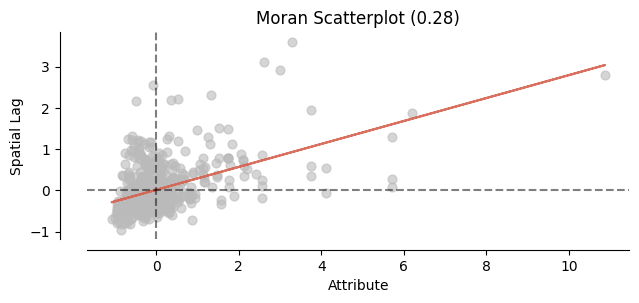

In [372]:
fig, ax = moran_scatterplot(mi, aspect_equal=True)
plt.show()